<a href="https://colab.research.google.com/github/Marshelix/autopilot/blob/master/CarProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tensorflow.keras.preprocessing.image as imgprep

# Data loading
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

import random
import os

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Adam stuff
import pandas as pd
import logging
import sys

logging.basicConfig(level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("car_log.txt"),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger("CarAi")
logger.debug("File created. Starting Log.")
from google.colab import drive
drive.mount('/content/gdrive')

2020-05-02 07:15:58,906 [DEBUG] File created. Starting Log.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
2020-05-02 07:16:19,025 [DEBUG] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [0]:

root_folder = 'gdrive/My Drive/Colab Notebooks'

model_output_dir = root_folder + "/models/"


mode = "**"

results = {}

In [0]:
def load_test_dataset(resize_percent = 60):
    dirname = root_folder+"/test_data/test_data/**.png"
    fnames_full = glob.glob(dirname, recursive = True)
    logger.debug(str(len(fnames_full)) + " names found.")
    images = [[] for i in range(len(fnames_full))]  #override image according to name
    k = 1
    for fname in fnames_full:
        logger.debug("Loading {}. Image {}/{}".format(fname,k,len(fnames_full)))
        img = pltimg.imread(fname)
        width = int(img.shape[1] * resize_percent / 100)
        height = int(img.shape[0] * resize_percent / 100)
        dim = (width, height)
        resized = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
        name_idx = int(fname.split("/")[-1].split(".")[0])-1
        images[name_idx] = resized
        k += 1
    return np.asarray([images])

def load_adam_dataset(resize_percent = 60):
    train_df = pd.read_csv(root_folder+"/training_norm.csv")
    train_df.index = train_df["image_id"]
    angles = train_df.angle
    speed = train_df.speed
    targets = []
    images = []
    dirname = root_folder+"/training_data/**/*.png"
    logger.info("Loading data from "+dirname)
    fnames_full = glob.glob(dirname,recursive = True)
    logger.info(str(len(fnames_full)) + " names found")
    for fname in fnames_full:
        fname_split = fname.split("/")
        logger.debug("Loading {}".format(fname))
        name = fname_split[-1]
        img = pltimg.imread(fname)
        width = int(img.shape[1] * resize_percent / 100)
        height = int(img.shape[0] * resize_percent / 100)
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        images.append(resized)
        targets.append([float(train_df.angle[int(name.split(".")[0])]),float(train_df.speed[int(name.split(".")[0])])])
    return images,targets

In [0]:
adam_images,adam_targets = load_adam_dataset()


2020-05-02 07:16:30,652 [INFO] Loading data from gdrive/My Drive/Colab Notebooks/training_data/**/*.png
2020-05-02 07:16:34,108 [INFO] 454 names found
2020-05-02 07:16:34,109 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/11.png
2020-05-02 07:16:34,712 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/101.png
2020-05-02 07:16:35,203 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/10.png
2020-05-02 07:16:35,855 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/110.png
2020-05-02 07:16:36,498 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/103.png
2020-05-02 07:16:37,109 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/107.png
2020-05-02 07:16:37,483 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_data/112.png
2020-05-02 07:16:38,176 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/training_data/training_

In [0]:
# Construct checkpoints
class PredictionCallback(tf.keras.callbacks.Callback):
    """On an improved epoch, make predictions for the assessment data
    
    Arguments:
        test_images: the assessment data you want predictions for every
        time the model improves.
        global_best: the best MSE loss score across all your models.
    """

    def __init__(self, test_images, global_best=np.Inf,save_path = "./prediction_intermediate.csv"):
        super(PredictionCallback, self).__init__()

        self.test_images = test_images
        self.global_best = global_best
        if save_path is not None:
          self.save = save_path
        else:
          self.save = "./prediction_intermediate.csv"

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.global_best):
            print("Epoch improved on best global score - making predictions on hold-out dataset")
            self.global_best = current
            self.make_prediction()

    def make_prediction(self):
        colnames = ["angle","speed"]
        prediction = model.predict(test_images[0])
        df = pd.DataFrame(prediction, columns = colnames)
        df["image_id"] = range(1, len(test_images[0])+1)
        df = df.reindex(columns = ["image_id","angle","speed"])
        df.index = df["image_id"]
        df = df[["angle","speed"]]
        #write
        df.to_csv(self.save)

In [0]:
def load_dataset(resize_percent =  60,res_speed = [0.0,1.0]):
  '''
  Load dataset. Restriction possible in speed, as adam_data speed hist != own speed dist
  '''
  images = []
  targets = []
  dirname = root_folder+"/data/**/*.png"
  logger.info("Loading data from "+dirname)
  fnames_full = glob.glob(dirname,recursive = True)
  logger.info(str(len(fnames_full)) + " names found")
  i = 1
  for fname in fnames_full:
      fname_split = fname.split("/")
        
      name = fname_split[-1]
      logger.debug("Loading {}. File {}/{}".format(fname,i,len(fnames_full)))
      speed = (float(name.split(".")[0].split("_")[2]))/35.0
      angle = (float(name.split(".")[0].split("_")[1])-50.0)/80.0
      img = pltimg.imread(fname)
      width = int(img.shape[1] * resize_percent / 100)
      height = int(img.shape[0] * resize_percent / 100)
      dim = (width, height)
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
      i+=1
      if res_speed is None:
        images.append(resized)
        targets.append([float(angle),float(speed)])
      elif float(speed) in res_speed:
        images.append(resized)
        targets.append([float(angle),float(speed)])
        
  return images, targets

In [0]:
imgs, targets = load_dataset()


2020-05-02 07:20:25,794 [INFO] Loading data from gdrive/My Drive/Colab Notebooks/data/**/*.png
2020-05-02 07:20:31,373 [INFO] 2638 names found
2020-05-02 07:20:31,374 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705631085_85_35.png. File 1/2638
2020-05-02 07:20:31,725 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705658369_90_35.png. File 2/2638
2020-05-02 07:20:32,019 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705557308_90_35.png. File 3/2638
2020-05-02 07:20:32,320 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705620644_110_35.png. File 4/2638
2020-05-02 07:20:32,612 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705564577_80_35.png. File 5/2638
2020-05-02 07:20:32,920 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/data/captureOVAL-28_02_2020/1581705536529_80_35.png. File 6/2638
2020-05-02 07:20:33,218 [DEBUG] Lo

In [0]:
imgs = imgs + adam_images
targets = targets + adam_targets
in_shape = imgs[0].shape
X_train, X_valid, y_train, y_valid = train_test_split( imgs, targets, test_size=0.2)
logger.info("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

2020-05-02 07:35:40,016 [INFO] Training data: 2262
Validation data: 566


In [0]:
#Define Model:
def Model():
    model = Sequential()
    model.add(BatchNormalization(input_shape = in_shape))
    model.add(Conv2D(12,(5,5),strides = (2,2),input_shape = in_shape,activation = "elu"))
    model.add(Conv2D(30,(3,3),strides = (2,2), activation = "elu"))
    model.add(Conv2D(40,(5,5),strides = (2,2), activation = "elu"))
    model.add(Conv2D(64,(5,5),strides = (2,2), activation = "elu"))
    
    #fully connected output
    model.add(Flatten())
    model.add(Dense(100, activation = "elu"))
    model.add(Dense(50, activation = "elu"))
    model.add(Dense(20, activation = "elu"))
    model.add(Dense(2,activation = "elu"))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

model = Model()
logger.info(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 144, 192, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 94, 12)        912       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 46, 30)        3270      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 21, 40)        30040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 64)          64064     
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [0]:
def image_data_gen(imgs, targets,batch_size):
    while True:
        batch_images = []
        batch_targets = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs)-1)
            img = imgs[random_index]
            target = targets[random_index]
            batch_images.append(img)
            batch_targets.append(target)
        yield(np.asarray(batch_images), np.asarray(batch_targets))

aug = imgprep.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=False, fill_mode="nearest")


In [0]:
#create prediction
colnames = ["angle","speed"]
test_images = load_test_dataset()
best_loss = 0.02821311727166176;

2020-05-02 07:35:53,549 [DEBUG] 927 names found.
2020-05-02 07:35:53,550 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/1.png. Image 1/927
2020-05-02 07:35:53,924 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/10.png. Image 2/927
2020-05-02 07:35:54,250 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/104.png. Image 3/927
2020-05-02 07:35:54,596 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/102.png. Image 4/927
2020-05-02 07:35:54,984 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/106.png. Image 5/927
2020-05-02 07:35:55,360 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/101.png. Image 6/927
2020-05-02 07:35:55,742 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/107.png. Image 7/927
2020-05-02 07:35:56,083 [DEBUG] Loading gdrive/My Drive/Colab Notebooks/test_data/test_data/100.png. Image 8/927
2020-05-02 07:35:56,435 [DEBUG] Loading gdrive/My 

In [0]:
csvlogger = tf.keras.callbacks.CSVLogger('training.log')
prediction_callback = PredictionCallback(test_images,best_loss,root_folder+"/prediction_intermediate.csv")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'AI_driver_check_all.h5'), verbose=1, save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
history = model.fit_generator(aug.flow(np.array(X_train),y_train,batch_size = 100),
                              steps_per_epoch=300,
                              epochs=100,
                              validation_data = image_data_gen(X_valid,y_valid,100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback,es_callback,csvlogger,prediction_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
2020-05-02 07:41:14,617 [WARNING] From <ipython-input-12-fe8ccea0a552>:12: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.1050
Epoch 00001: val_loss improved from inf to 0.08497, saving model to gdrive/My Drive/Colab Notebooks/models/AI_driver_check_all.h5
300/300 [==============================] - 167s 558ms/step - loss: 0.1050 - val_loss: 0.0850
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.0790
Epoch 00002: val_loss improved from 0.08497 to 0.07478, saving model to gdrive/My Drive/Colab Notebooks/models/AI_driver_check_all.h5
300/300 [==============================] - 168s 560ms/step - loss: 0.0790 - val_loss: 0.0748
Epoch 3/100
300/300 [========================

2020-05-02 10:02:06,335 [DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-05-02 10:02:06,337 [DEBUG] findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2020-05-02 10:02:06,338 [DEBUG] findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-05-02 10:02:06,340 [DEBUG] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-05-02 10:02:06,340 [DEBUG] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2020-05-02 10:02:06,341 [DEBUG] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
2020-05-02 10:02:06,342 [DEBUG] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2020-05-02 10:02:06,343 [DEBUG] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) 

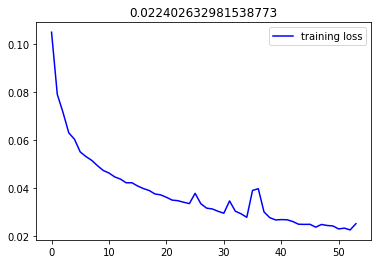

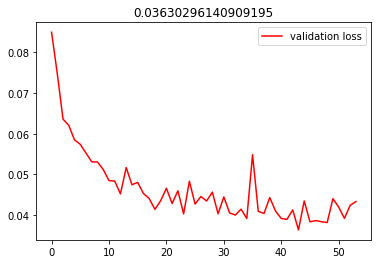

In [0]:
name = os.path.join(model_output_dir,'AI_driver_all.h5')


plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.legend(["training loss"])
plt.title(str(np.min(history.history["loss"])))
if np.min(history.history["val_loss"]) < best_loss:
    plt.savefig(root_folder+"/training_loss.png")
plt.figure()
plt.plot(history.history['val_loss'],color='red')
plt.legend([ "validation loss"])
plt.title(str(np.min(history.history["val_loss"])))
if np.min(history.history["val_loss"]) < best_loss:  
    plt.savefig(root_folder+"/valid_loss.png");
results[mode] = [history.history['loss'][-1],history.history['val_loss'][-1]]




In [0]:
prediction = model.predict(test_images[0])
df = pd.DataFrame(prediction, columns = colnames)
df["image_id"] = range(1,928)
df = df.reindex(columns = ["image_id","angle","speed"])
df.index = df["image_id"]
df = df[["angle","speed"]]
#write model and prediction to file if better than best loss.
if np.min(history.history["val_loss"]) < best_loss:
    logging.info("New best loss: {}".format(np.min(history.history["val_loss"])))
    model.save(name)
    df.to_csv(root_folder+"/prediction.csv")